In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, plot_confusion_matrix, precision_recall_curve
from sklearn.utils import shuffle
import seaborn as sns
from PIL import Image
from tensorflow.keras import backend as K    
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Methods for Experiments

In [2]:
# data distribution
def get_distr(targets, labels):
    vals = {}
    for label in labels.keys():
        vals[label] = 0
    
    for target in targets:
        vals[target] += 1
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    langs = labels.values()
    students = vals.values()
    ax.bar(langs,students)
    plt.show()

In [3]:
# Image normalization
img_dim = 224
def normalize_images(d, curr_dir):
    """normalize all images inside dictionary"""
    images = np.empty((len(d['target']), img_dim, img_dim, 3))

    for i in range(len(d['filename'])):
        image = Image.open(curr_dir + d['filename'][i])

        # resize image shape
        image = image.resize((img_dim, img_dim))

        # convert to grayscale
        image = image.convert('RGB')

        images[i] = np.array(image)

    # normalize values
    images = images / 255.0
    return images

In [4]:
# Data Augmentation
aug_count = 8
def augment_images(images, targets):
    data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal", dtype='float64'),
      layers.experimental.preprocessing.RandomRotation(0.05, dtype='float64')
    ])
    
    aug_images = np.empty((len(targets) * (aug_count + 1), img_dim, img_dim, 3))
    new_targets = []
    
    
    for i in range(len(targets)):
        image = tf.expand_dims(images[i], 0)
        for j in range(0, aug_count):
            new_image = data_augmentation(image)
            new_targets.append(targets[i])
            aug_images[len(new_targets) - 1] = new_image[0]
        
        # add base image
        new_targets.append(targets[i])
        aug_images[len(new_targets) - 1] = images[i]
    
    return np.asarray(aug_images), new_targets

In [5]:
# Get data to test on
def split_data(images, targets, split_size):
    x_train, x_test, y_train, y_test = train_test_split(images, targets, test_size=split_size, random_state=0)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=split_size, random_state=0)
    y_train = np.asarray(y_train)
    y_val = np.asarray(y_val)
    y_test = np.asarray(y_test)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [6]:
def graph_correlation(images, targets, classes):
    reshaped_images = np.empty((len(targets), img_dim * img_dim * 2))
    for i in range(len(targets)):
        reshaped_images[i] = images[i].ravel()

    pca = PCA(n_components=2)
    redData = pca.fit_transform(reshaped_images)
    # append target values to reduced data
    redData = np.append(redData, np.asarray(targets).reshape(-1, 1), axis=1)
     # create scatter plot of reduced data
    # add scatter plot for each of the target values
    for curr in classes:
        currClass = np.where(np.asarray(d['target']) == curr)
        plt.scatter(redData[:, 0][currClass], redData[:, 1][currClass])
        plt.legend(classes)

In [7]:
def convert_pred(y_pred, threshold):
    new_pred = np.empty((y_pred.size), dtype='int32')
    for i in range(y_pred.size):
        if y_pred[i] >= threshold:
            new_pred[i] = 1
        else:
            new_pred[i] = 0
    
    return new_pred

Results functions

In [8]:
# accuracy and loss plots
def plot_results(history, title):
    # plot accuracy and loss curves
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(history.history['accuracy'], label='training accuracy')
    axs[0].plot(history.history['val_accuracy'], label = 'val accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title((title + ' Accuracy'))
    axs[0].set_ylim([0.5, 1])
    axs[0].legend(loc='lower right')

    axs[1].plot(history.history['loss'], label='training loss')
    axs[1].plot(history.history['val_loss'], label = 'val loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title((title + ' CNN Loss'))
    axs[1].set_ylim([0, 1])
    axs[1].legend(loc='lower right')

In [9]:
# ROC Plots
def plot_ROC(y_test, y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_val = auc(fpr, tpr)

    plt.plot(fpr,tpr) 
    plt.plot([0, 1], [0, 1], linestyle='dashed')
    plt.axis([-0.05, 1.05, -0.05, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    title += "\nAUC: " + str(round(auc_val, 4))
    plt.title(title)
    plt.show()

In [10]:
# Confusion Matrix
def plot_cm(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)
    cm_df = (cm_df.T/np.sum(cm_df, axis=1)).T
    sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues, fmt=".2%")
    plt.imshow(cm)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)

In [11]:
def plot_pr(y_test, y_pred, title):
    prec, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, prec)
    plt.ylim([0, 1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title + " Precision vs Recall")

# Part 0: Load in data

In [12]:
# covid/pneumonia
data = []
with open("metadata.csv") as file:
    for row in csv.reader(file):
        data.append(row)

data = data[1:]

# pneumonia/healthy
# format: (file location, healthy/pneumonia(0/1))
ph_files = [('train/Normal', 0), 
         ('train/Pneumonia', 1),
         ('test/Normal', 0), 
         ('test/Pneumonia', 1),
         ('val/Normal', 0), 
         ('val/Pneumonia', 1),]

COVID/Pneumonia

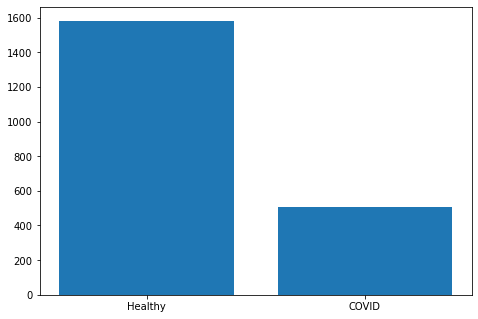

In [13]:
ch = {'filename': [], 'target': []}

# covid/pneumonia data
for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis1 = image[4].split("/")
    diagnosis = diagnosis1[len(diagnosis1) - 1].lower()
    # set target based on meta data
    if diagnosis == "covid-19":
        # if it is COVID-19
        ch['filename'].append(image[23])
        ch['target'].append(1)
        
# healthy from pneumonia/healthy
for file in ph_files:
    if "normal" in file[0].lower():
        dir_path = os.path.abspath(os.getcwd())
        dir_path = dir_path + "/chest_xray/" + file[0]
        list = os.listdir(dir_path)
        for pic in list:
            if '.DS_Store' not in pic:
                ch['filename'].append(pic)
                ch['target'].append(0)

# get distribution
labels = {0: "Healthy", 1: "COVID"}
get_distr(ch['target'], labels)


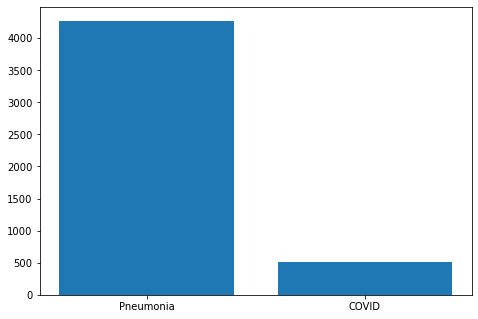

In [14]:
cp = {'filename': [], 'target': []}

# covid/pneumonia data
for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis1 = image[4].split("/")
    diagnosis = diagnosis1[len(diagnosis1) - 1].lower()
    # set target based on meta data
    if diagnosis == "covid-19":
        # if it is COVID-19
        cp['filename'].append(image[23])
        cp['target'].append(1)
        
# pneumonia from pneumonia/healthy
for file in ph_files:
    if "pneumonia" in file[0].lower():
        dir_path = os.path.abspath(os.getcwd())
        dir_path = dir_path + "/chest_xray/" + file[0]
        list = os.listdir(dir_path)
        for pic in list:
            if '.DS_Store' not in pic:
                cp['filename'].append(pic)
                cp['target'].append(0)

# get distribution
labels = {0: "Pneumonia", 1: "COVID"}
get_distr(cp['target'], labels)


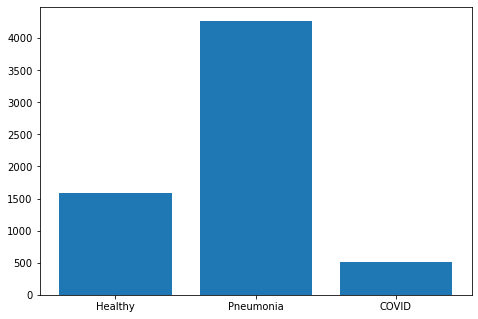

In [15]:
cph = {'filename': [], 'target': []}

# covid/pneumonia data
for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis1 = image[4].split("/")
    diagnosis = diagnosis1[len(diagnosis1) - 1].lower()
    # set target based on meta data
    if diagnosis == "covid-19":
        # if it is COVID-19
        cph['filename'].append(image[23])
        cph['target'].append(2)
        
# pneumonia from pneumonia/healthy
for file in ph_files:
    dir_path = os.path.abspath(os.getcwd())
    dir_path = dir_path + "/chest_xray/" + file[0]
    list = os.listdir(dir_path)
    for pic in list:
        if '.DS_Store' not in pic:
            cph['filename'].append(pic)
            cph['target'].append(file[1])

# get distribution
labels = {0: "Healthy", 1: "Pneumonia", 2: "COVID"}
get_distr(cph['target'], labels)


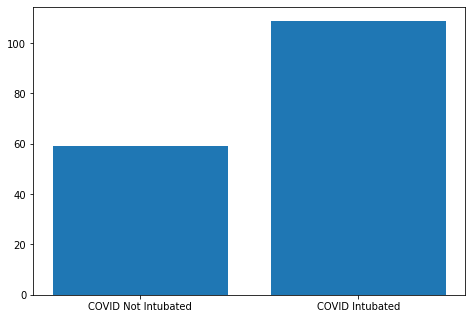

In [16]:
cc = {'filename': [], 'target': []}

# covid/pneumonia data
for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis1 = image[4].split("/")
    diagnosis = diagnosis1[len(diagnosis1) - 1].lower()
    # set target based on meta data
    if diagnosis == "covid-19":
        # if it is COVID-19
        if image[7] == "Y":
            # patient intubated
            cc['filename'].append(image[23])
            cc['target'].append(1)
        elif image[7] == "N":
            # patient not intubated
            cc['filename'].append(image[23])
            cc['target'].append(0)


# get distribution
labels = {0: "COVID Not Intubated", 1: "COVID Intubated"}
get_distr(cc['target'], labels)

Plan:
1. COVID/Healthy
2. COVID/Pneumonia
3. COVID/Pneumonia/Healthy
4. COVID Not Intubated/COVID Intubated

Test on (use Random Search CV for Hyper Params)
1. Deep CNN

Test Each with
1. Not augmented
2. Augmented

## Create Model

In [17]:
def create_model(num_classes=2, lr=0.001, do=0.2, layer_size=1024):
    act = 'softmax'
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = ['accuracy']
    
    if num_classes == 2:
        num_classes = 1
        act = 'sigmoid'
        loss = tf.keras.losses.BinaryCrossentropy()
        metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
        
    base_model = tf.keras.applications.VGG19(weights='imagenet', 
                                             include_top=False,
                                             input_shape=(224, 224, 3),
                                             classifier_activation=act)
    
    base_model.trainable = False

    flatten = layers.Flatten()(base_model.layers[-1].output)
    dense = layers.Dense(layer_size, activation='relu')(flatten)
    output = layers.Dense(num_classes, activation=act)(dense)
    
    # define new model
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output)

    opt = tf.keras.optimizers.Adam(lr=lr)
    # compile 
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=metrics)
    
    return model 

# Hyper Parameter Selection for models

In [18]:
lr = 0.001
do = 0.2
bs = 16
threshold = 0.5


# early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.01,
        patience=2,
        verbose=1
    )
]  

# Part 1: VGG19 No Augmentation

## 1. COVID/Healthy

In [133]:
ch_images = normalize_images(ch, "all_images/")

In [134]:
chx_train, chy_train, chx_val, chy_val, chx_test, chy_test = split_data(ch_images, ch['target'], .2)

In [135]:
ch_model = create_model(num_classes=2)

ch_history = ch_model.fit(chx_train, np.asarray(chy_train), epochs=10,
                               validation_data=(chx_val, chy_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
84/84 [==============================] - 164s 2s/step - loss: 0.6215 - recall_3: 0.9164 - precision_3: 0.9338 - val_loss: 0.1459 - val_recall_3: 0.8590 - val_precision_3: 1.0000
Epoch 2/10
84/84 [==============================] - 172s 2s/step - loss: 0.0315 - recall_3: 0.9721 - precision_3: 0.9905 - val_loss: 0.0345 - val_recall_3: 0.9744 - val_precision_3: 0.9744
Epoch 3/10
84/84 [==============================] - 171s 2s/step - loss: 0.0067 - recall_3: 0.9969 - precision_3: 0.9969 - val_loss: 0.0409 - val_recall_3: 0.9744 - val_precision_3: 0.9744
Epoch 4/10
84/84 [==============================] - 168s 2s/step - loss: 5.0020e-05 - recall_3: 1.0000 - precision_3: 1.0000 - val_loss: 0.0407 - val_recall_3: 0.9744 - val_precision_3: 0.9744
Epoch 00004: early stopping


In [136]:
chy_pred = ch_model.predict(chx_test)

In [137]:
chy_pred_norm = convert_pred(chy_pred, threshold)

In [138]:
print(classification_report(chy_test, chy_pred_norm))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       315
           1       0.99      0.98      0.99       103

    accuracy                           0.99       418
   macro avg       0.99      0.99      0.99       418
weighted avg       0.99      0.99      0.99       418



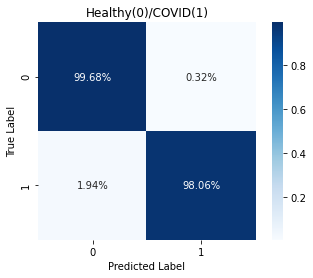

In [139]:
plot_cm(chy_test, chy_pred_norm, "Healthy(0)/COVID(1)")

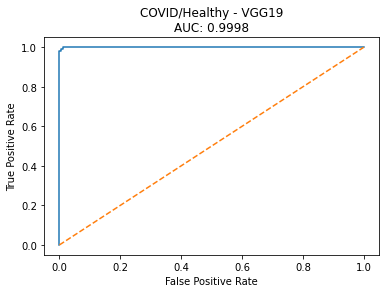

In [140]:
plot_ROC(chy_test, chy_pred, "COVID/Healthy - VGG19")

## 2. COVID/Pneumonia

In [142]:
cp_images = normalize_images(cp, "all_images/")

In [143]:
cpx_train, cpy_train, cpx_val, cpy_val, cpx_test, cpy_test = split_data(cp_images, cp['target'], .2)

In [144]:
cp_model = create_model(2)

In [145]:
cp_history = cp_model.fit(cpx_train, np.asarray(cpy_train), epochs=10,
                               validation_data=(cpx_val, cpy_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
191/191 [==============================] - 373s 2s/step - loss: 0.5875 - recall_4: 0.8044 - precision_4: 0.8147 - val_loss: 0.1283 - val_recall_4: 0.7683 - val_precision_4: 1.0000
Epoch 2/10
191/191 [==============================] - 383s 2s/step - loss: 0.0392 - recall_4: 0.9464 - precision_4: 0.9585 - val_loss: 0.1691 - val_recall_4: 1.0000 - val_precision_4: 0.7961
Epoch 3/10
191/191 [==============================] - 388s 2s/step - loss: 0.0042 - recall_4: 0.9937 - precision_4: 0.9937 - val_loss: 0.0444 - val_recall_4: 0.9390 - val_precision_4: 0.9872
Epoch 4/10
191/191 [==============================] - 395s 2s/step - loss: 0.0020 - recall_4: 0.9968 - precision_4: 0.9968 - val_loss: 0.0459 - val_recall_4: 1.0000 - val_precision_4: 0.9318
Epoch 5/10
191/191 [==============================] - 379s 2s/step - loss: 0.0052 - recall_4: 0.9905 - precision_4: 0.9905 - val_loss: 0.0228 - val_recall_4: 0.9634 - val_precision_4: 0.9875
Epoch 6/10
191/191 [=========================

In [146]:
cpy_pred = cp_model.predict(cpx_test)

In [147]:
cpy_pred_norm = convert_pred(cpy_pred, threshold)

In [148]:
print(classification_report(cpy_test, cpy_pred_norm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       851
           1       0.99      1.00      1.00       105

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956



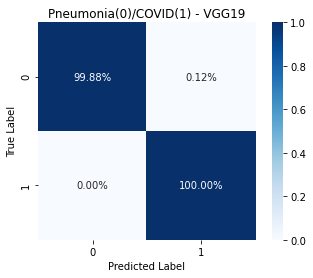

In [149]:
plot_cm(cpy_test, cpy_pred_norm, "Pneumonia(0)/COVID(1) - VGG19")

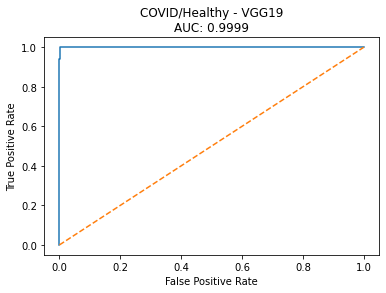

In [150]:
plot_ROC(cpy_test, cpy_pred, "COVID/Healthy - VGG19")

## 3. COVID/Pnuemonia/Healthy

In [19]:
cph_images = normalize_images(cph, "all_images/")

In [20]:
cphx_train, cphy_train, cphx_val, cphy_val, cphx_test, cphy_test = split_data(cph_images, cph['target'], .2)

In [21]:
cph_model = create_model(3)

cph_history = cph_model.fit(cphx_train, np.asarray(cphy_train), epochs=10,
                               validation_data=(cphx_val, cphy_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
255/255 [==============================] - 464s 2s/step - loss: 0.8216 - accuracy: 0.8995 - val_loss: 0.3216 - val_accuracy: 0.9352
Epoch 2/10
255/255 [==============================] - 482s 2s/step - loss: 0.1948 - accuracy: 0.9555 - val_loss: 0.2867 - val_accuracy: 0.9283
Epoch 3/10
255/255 [==============================] - 494s 2s/step - loss: 0.1352 - accuracy: 0.9629 - val_loss: 0.2139 - val_accuracy: 0.9361
Epoch 4/10
255/255 [==============================] - 539s 2s/step - loss: 0.0639 - accuracy: 0.9767 - val_loss: 0.1306 - val_accuracy: 0.9597
Epoch 5/10
255/255 [==============================] - 539s 2s/step - loss: 0.0784 - accuracy: 0.9722 - val_loss: 0.1311 - val_accuracy: 0.9597
Epoch 6/10
255/255 [==============================] - 558s 2s/step - loss: 0.0601 - accuracy: 0.9776 - val_loss: 0.2549 - val_accuracy: 0.9371
Epoch 00006: early stopping


In [22]:
cphy_pred = cph_model.predict(cphx_test)

In [23]:
cphy_pred_norm = np.empty(cphy_test.size, dtype='int32')

for i in range(cphy_test.size):
    ind = np.argmax(cphy_pred[i])
    cphy_pred_norm[i] = ind

In [24]:
print(classification_report(cphy_test, cphy_pred_norm))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86       314
           1       0.92      0.99      0.96       851
           2       0.96      0.99      0.98       107

    accuracy                           0.94      1272
   macro avg       0.96      0.92      0.93      1272
weighted avg       0.94      0.94      0.93      1272



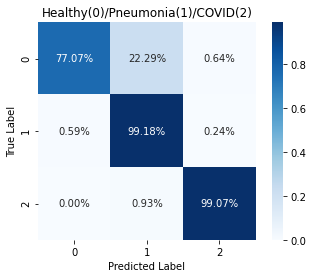

In [25]:
plot_cm(cphy_test, cphy_pred_norm, "Healthy(0)/Pneumonia(1)/COVID(2)")

## 4. COVID Not Intubated/COVID Intubated

In [106]:
cc_images = normalize_images(cc, "all_images/")

In [107]:
ccx_train, ccy_train, ccx_val, ccy_val, ccx_test, ccy_test = split_data(cc_images, cc['target'], .2)

In [108]:
cc_model = create_model(2)

cc_history = cc_model.fit(ccx_train, np.asarray(ccy_train), epochs=10,
                               validation_data=(ccx_val, ccy_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
7/7 [==============================] - 12s 2s/step - loss: 7.0241 - recall: 0.6522 - precision: 0.6429 - val_loss: 3.7040 - val_recall: 1.0000 - val_precision: 0.5556
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 1.2553 - recall: 0.7391 - precision: 0.8095 - val_loss: 2.9240 - val_recall: 1.0000 - val_precision: 0.5556
Epoch 3/10
7/7 [==============================] - 12s 2s/step - loss: 0.6157 - recall: 0.8261 - precision: 0.8382 - val_loss: 1.3512 - val_recall: 1.0000 - val_precision: 0.6818
Epoch 4/10
7/7 [==============================] - 12s 2s/step - loss: 0.4641 - recall: 0.9710 - precision: 0.8272 - val_loss: 0.6402 - val_recall: 0.6000 - val_precision: 0.8182
Epoch 5/10
7/7 [==============================] - 12s 2s/step - loss: 0.1999 - recall: 0.9420 - precision: 0.9155 - val_loss: 0.6526 - val_recall: 0.9333 - val_precision: 0.6667
Epoch 6/10
7/7 [==============================] - 12s 2s/step - loss: 0.0512 - recall: 1.0000 - precision: 1.0

In [109]:
ccy_pred = cc_model.predict(ccx_test)

In [110]:
ccy_pred_norm = convert_pred(ccy_pred, threshold)

In [111]:
print(classification_report(ccy_test, ccy_pred_norm))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.88      0.84      0.86        25

    accuracy                           0.79        34
   macro avg       0.74      0.75      0.74        34
weighted avg       0.80      0.79      0.80        34



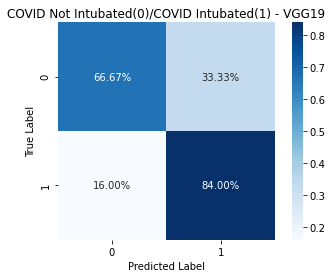

In [112]:
plot_cm(ccy_test, ccy_pred_norm, "COVID Not Intubated(0)/COVID Intubated(1) - VGG19")

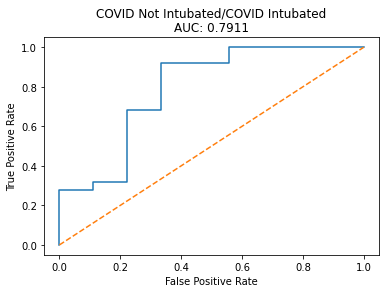

In [113]:
plot_ROC(ccy_test, ccy_pred, "COVID Not Intubated/COVID Intubated")

# Part 1: VGG19 With Augmentation

## 1. COVID Not Intubated/COVID Intubated Augmented

In [124]:
ccax_train, ccay_train, ccax_val, ccay_val, ccax_test, ccay_test = split_data(cc_images, cc['target'], .25)

In [125]:
ccax_train, ccay_train = augment_images(ccax_train, ccay_train)

In [126]:
cca_model = create_model(2)

cca_history = cca_model.fit(ccax_train, np.asarray(ccay_train), epochs=10,
                               validation_data=(ccax_val, ccay_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
53/53 [==============================] - 86s 2s/step - loss: 1.0176 - recall_2: 0.8199 - precision_2: 0.8030 - val_loss: 0.6172 - val_recall_2: 0.9500 - val_precision_2: 0.7600
Epoch 2/10
53/53 [==============================] - 91s 2s/step - loss: 0.2477 - recall_2: 0.9291 - precision_2: 0.9134 - val_loss: 0.9659 - val_recall_2: 0.7000 - val_precision_2: 0.8750
Epoch 3/10
53/53 [==============================] - 92s 2s/step - loss: 0.0840 - recall_2: 0.9808 - precision_2: 0.9715 - val_loss: 0.6417 - val_recall_2: 0.8500 - val_precision_2: 0.8500
Epoch 00003: early stopping


In [127]:
ccay_pred = cca_model.predict(ccax_test)

In [128]:
ccay_pred_norm = convert_pred(ccay_pred, threshold)

In [129]:
print(classification_report(ccay_test, ccay_pred_norm))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.87      0.87      0.87        31

    accuracy                           0.81        42
   macro avg       0.75      0.75      0.75        42
weighted avg       0.81      0.81      0.81        42



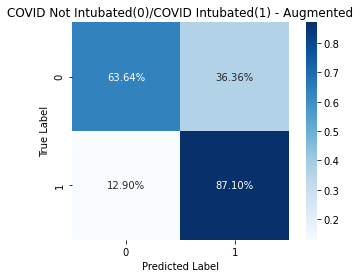

In [130]:
plot_cm(ccay_test, ccay_pred_norm, "COVID Not Intubated(0)/COVID Intubated(1) - Augmented")

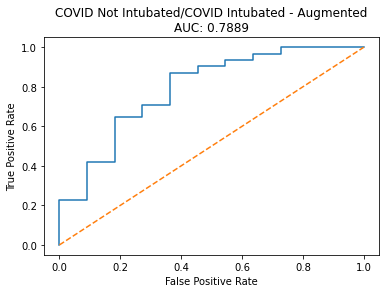

In [131]:
plot_ROC(ccay_test, ccay_pred, "COVID Not Intubated/COVID Intubated - Augmented")

## 2. COVID/Pneumonia/Healthy Augmented

In [32]:
cphax_train, cphay_train, cphax_val, cphay_val, cphax_test, cphay_test = split_data(cph_images, cph['target'], .25)

In [33]:
cphax_train, cphay_train = augment_images(cphax_train, cphay_train)

In [34]:
cpha_model = create_model(3)

cpha_history = cpha_model.fit(cphax_train, np.asarray(cphay_train), epochs=10,
                               validation_data=(cphax_val, cphay_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
2013/2013 [==============================] - 3044s 2s/step - loss: 0.3055 - accuracy: 0.9295 - val_loss: 0.1672 - val_accuracy: 0.9396
Epoch 2/10
2013/2013 [==============================] - 2904s 1s/step - loss: 0.1046 - accuracy: 0.9595 - val_loss: 0.1556 - val_accuracy: 0.9422
Epoch 3/10
2013/2013 [==============================] - 2898s 1s/step - loss: 0.0857 - accuracy: 0.9681 - val_loss: 0.0940 - val_accuracy: 0.9715
Epoch 4/10
2013/2013 [==============================] - 2874s 1s/step - loss: 0.0692 - accuracy: 0.9741 - val_loss: 0.0943 - val_accuracy: 0.9640
Epoch 5/10
2013/2013 [==============================] - 2885s 1s/step - loss: 0.0527 - accuracy: 0.9803 - val_loss: 0.1145 - val_accuracy: 0.9681
Epoch 00005: early stopping


In [35]:
cphay_pred = cpha_model.predict(cphax_test)

In [36]:
cphay_pred_norm = np.empty(cphay_test.size, dtype='int32')

for i in range(cphay_test.size):
    ind = np.argmax(cphay_pred[i])
    cphay_pred_norm[i] = ind

In [37]:
print(classification_report(cphay_test, cphay_pred_norm))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       392
           1       0.96      0.98      0.97      1067
           2       0.98      1.00      0.99       131

    accuracy                           0.96      1590
   macro avg       0.96      0.96      0.96      1590
weighted avg       0.96      0.96      0.96      1590



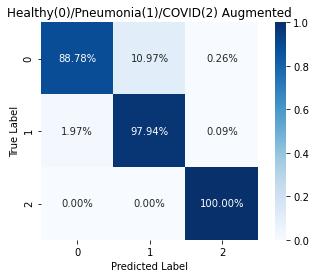

In [104]:
plot_cm(cphay_test, cphay_pred_norm, "Healthy(0)/Pneumonia(1)/COVID(2) Augmented")